In [1]:
import pandas as pd
import numpy as np

# --- 1. Load Data and Initial Inspection ---

# !!! CORRECTION: Using the relative path to go to the parent directory (..) !!!
# This tells the notebook (running in 'notebooks/') to look in the main folder.
DATA_FILE_PATH = '../benin-malanville.csv' 
df = pd.read_csv(DATA_FILE_PATH)

# Convert the Timestamp column to datetime and set it as the index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')

print("--- DataFrame Initial Info (Data Types and Non-Null Counts) ---")
df.info() 
print("\nDataFrame Head:")
print(df.head())

--- DataFrame Initial Info (Data Types and Non-Null Counts) ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2021-08-09 00:01:00 to 2022-08-09 00:00:00
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   GHI            525600 non-null  float64
 1   DNI            525600 non-null  float64
 2   DHI            525600 non-null  float64
 3   ModA           525600 non-null  float64
 4   ModB           525600 non-null  float64
 5   Tamb           525600 non-null  float64
 6   RH             525600 non-null  float64
 7   WS             525600 non-null  float64
 8   WSgust         525600 non-null  float64
 9   WSstdev        525600 non-null  float64
 10  WD             525600 non-null  float64
 11  WDstdev        525600 non-null  float64
 12  BP             525600 non-null  int64  
 13  Cleaning       525600 non-null  int64  
 14  Precipitation  525600 non-null  float64
 15  TModA          525600

In [2]:
# --- 2. Summary Statistics ---

print("\n--- Summary Statistics (df.describe()) ---")

# .T transposes the table for better readability
summary_stats = df.describe(include='all').T 
print(summary_stats)


--- Summary Statistics (df.describe()) ---
                  count        mean         std    min    25%    50%    75%  \
GHI            525600.0  240.559452  331.131327  -12.9   -2.0    1.8  483.4   
DNI            525600.0  167.187516  261.710501   -7.8   -0.5   -0.1  314.2   
DHI            525600.0  115.358961  158.691074  -12.6   -2.1    1.6  216.3   
ModA           525600.0  236.589496  326.894859    0.0    0.0    4.5  463.7   
ModB           525600.0  228.883576  316.536515    0.0    0.0    4.3  447.9   
Tamb           525600.0   28.179683    5.924297   11.0   24.2   28.0   32.3   
RH             525600.0   54.487969   28.073069    2.1   28.8   55.1   80.1   
WS             525600.0    2.121113    1.603466    0.0    1.0    1.9    3.1   
WSgust         525600.0    2.809195    2.029120    0.0    1.3    2.6    4.1   
WSstdev        525600.0    0.473390    0.273395    0.0    0.4    0.5    0.6   
WD             525600.0  153.435172  102.332842    0.0   59.0  181.0  235.1   
WDstdev 

In [3]:
# --- 3. Missing-Value Report ---

# Calculate total missing values per column
missing_total = df.isnull().sum()

# Calculate percentage of missing values per column
missing_percent = (df.isnull().sum() / len(df)) * 100

# Combine into a single report DataFrame, sorted by highest missing percentage
missing_report = pd.DataFrame({
    'Total Missing': missing_total,
    'Percent Missing': missing_percent
}).sort_values(by='Percent Missing', ascending=False)

print("\n--- Missing Value Report ---")
print(missing_report)


# --- 4. List Columns with > 5% Nulls (Priority for Cleaning) ---

HIGH_NULL_THRESHOLD = 5
# Filter the report to identify columns that need urgent attention
high_null_columns = missing_report[missing_report['Percent Missing'] > HIGH_NULL_THRESHOLD].index.tolist()

print(f"\n--- Columns with > {HIGH_NULL_THRESHOLD}% Nulls ---")
if high_null_columns:
    print(high_null_columns)
else:
    print("No columns found with more than 5% missing values.")


--- Missing Value Report ---
               Total Missing  Percent Missing
Comments              525600            100.0
GHI                        0              0.0
DNI                        0              0.0
DHI                        0              0.0
ModB                       0              0.0
ModA                       0              0.0
RH                         0              0.0
WS                         0              0.0
WSgust                     0              0.0
Tamb                       0              0.0
WSstdev                    0              0.0
WD                         0              0.0
BP                         0              0.0
WDstdev                    0              0.0
Cleaning                   0              0.0
Precipitation              0              0.0
TModA                      0              0.0
TModB                      0              0.0

--- Columns with > 5% Nulls ---
['Comments']


In [4]:
from scipy import stats

df_cleaned = df.copy()

# Columns specified for Z-score outlier detection 
Z_SCORE_COLS = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# 1. Calculate Z-scores (nan_policy='omit' ignores NaNs for calculation)
# Note: We must drop NaNs for the Z-score calculation to work correctly
z_scores = stats.zscore(df_cleaned[Z_SCORE_COLS].dropna(), nan_policy='omit')
z_scores_df = pd.DataFrame(z_scores, index=df_cleaned[Z_SCORE_COLS].dropna().index, columns=Z_SCORE_COLS)

# 2. Create an outlier mask: True if any Z-score is > 3 or < -3
outlier_mask = (np.abs(z_scores_df) > 3).any(axis=1)

# 3. Create the cleaned DataFrame by keeping rows that are NOT outliers (~)
df_cleaned = df_cleaned[~df_cleaned.index.isin(outlier_mask[outlier_mask].index)].copy()

print(f"Total rows flagged as outliers (|Z|>3): {outlier_mask.sum()}")
print(f"Rows remaining after outlier removal: {len(df_cleaned)}")

Total rows flagged as outliers (|Z|>3): 7740
Rows remaining after outlier removal: 517860


In [5]:
# --- Task 2, Step 3: Outlier Detection, Basic Cleaning & Export ---

# NOTE: This cell assumes 'df_cleaned' is the DataFrame after Z-score outlier removal
# and that the Z-score cell was run immediately prior to this one.

# Drop the entirely null 'Comments' column (as identified in the report)
# FIX: Added errors='ignore' so the code doesn't fail if run multiple times.
df_cleaned = df_cleaned.drop(columns=['Comments'], errors='ignore')

# A. Drop rows where key irradiance metrics are still missing (after outlier removal)
df_cleaned = df_cleaned.dropna(subset=['GHI', 'DNI', 'DHI'])

# B. Impute remaining numeric missing data using the median
for col in df_cleaned.columns:
    if df_cleaned[col].dtype in ['float64', 'int64'] and df_cleaned[col].isnull().any():
        median_val = df_cleaned[col].median()
        
        # Best Practice Fix: Assign back directly to avoid FutureWarning
        df_cleaned[col] = df_cleaned[col].fillna(median_val)

print(f"Final data ready for EDA after null handling: {len(df_cleaned)} rows.")

# --- Export Cleaned Data (Required Task) ---

# 1. Create the data folder if it doesn't exist (safe due to exist_ok=True)
import os
os.makedirs('data', exist_ok=True)

# 2. Export the cleaned data (This overwrites the existing file)
output_path = 'data/benin_clean.csv'
df_cleaned.to_csv(output_path, index=True)

print(f"Cleaned data for Benin exported successfully to: {output_path}")

Final data ready for EDA after null handling: 517860 rows.
Cleaned data for Benin exported successfully to: data/benin_clean.csv


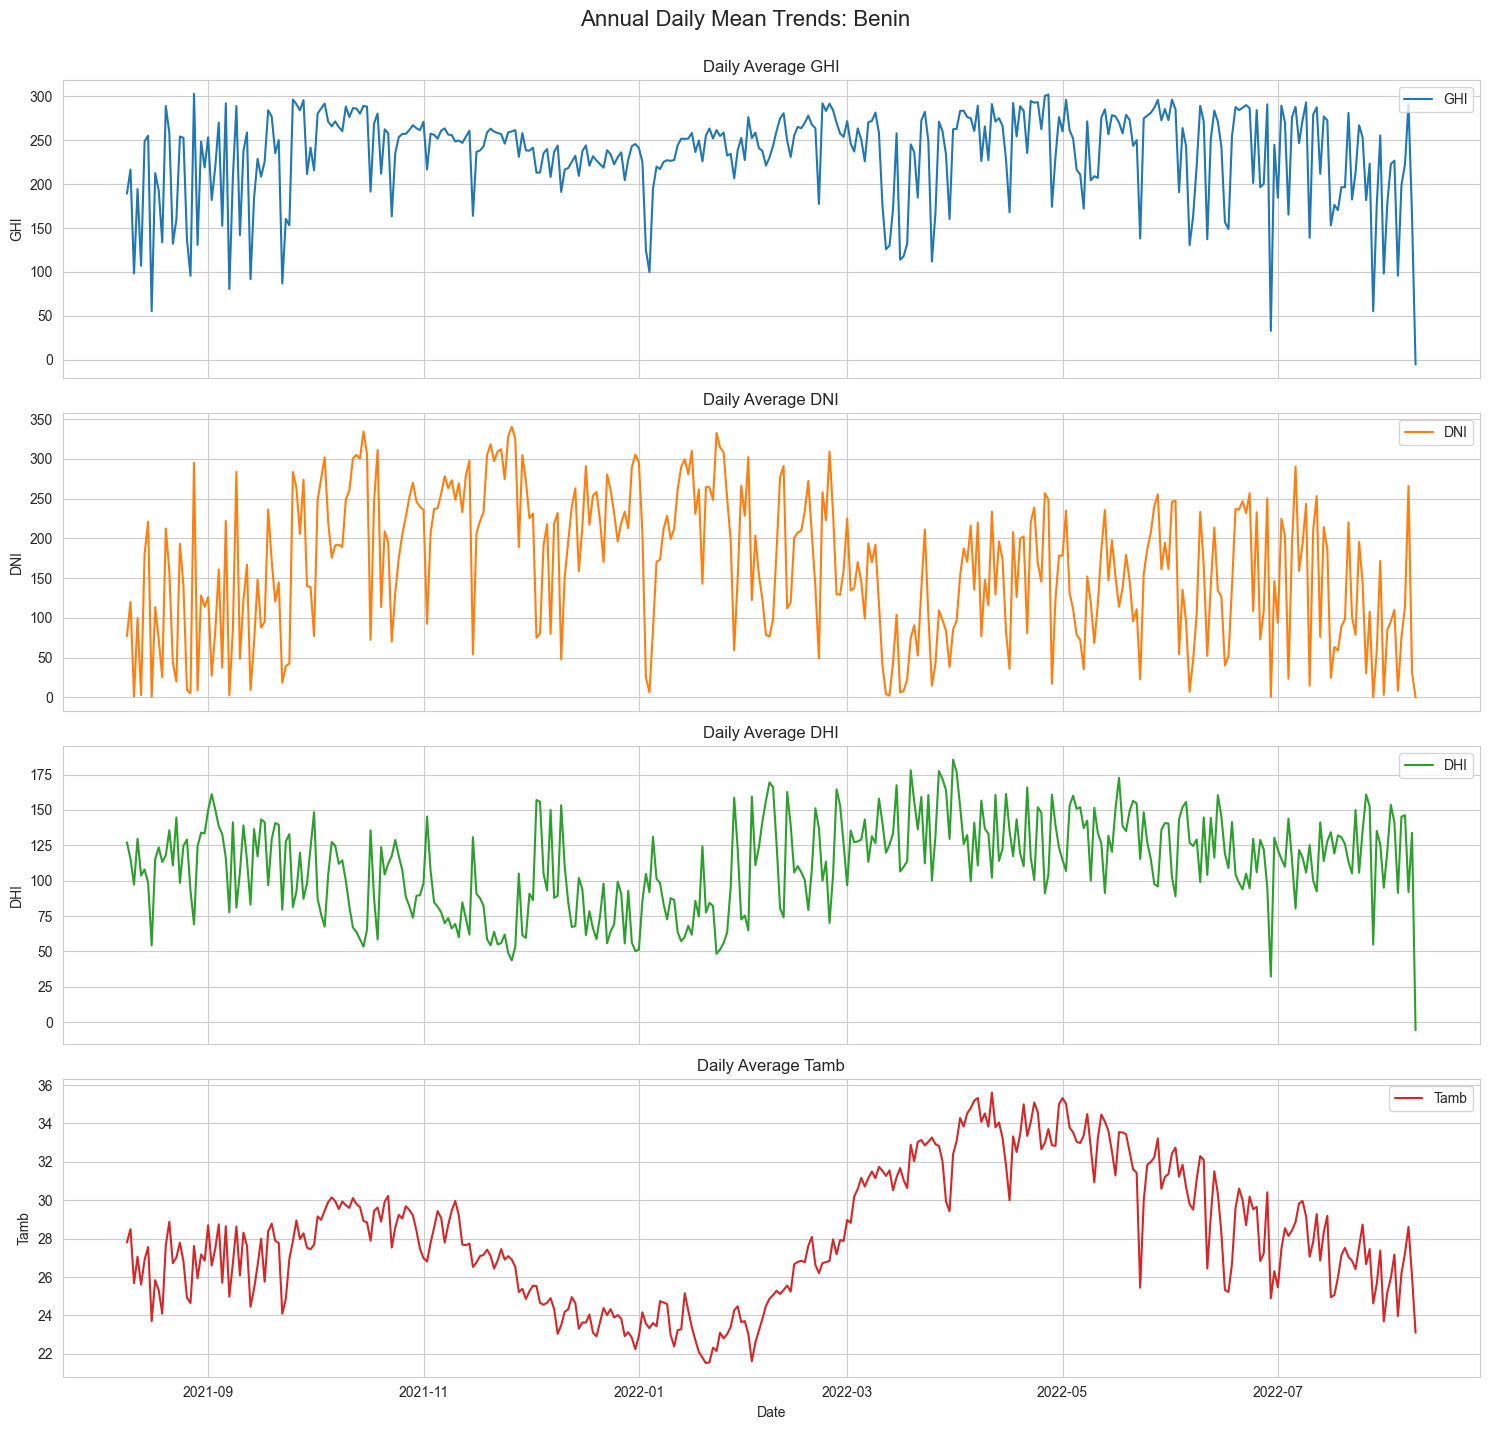

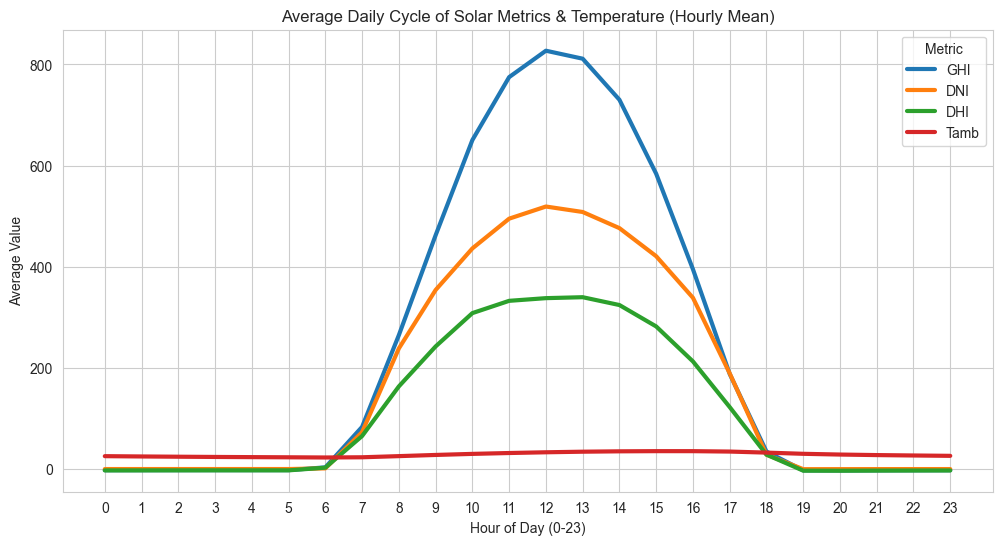

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- 1. Load Cleaned Data ---
# Load from the file you just exported using the correct relative path
df_clean = pd.read_csv('./data/benin_clean.csv', index_col='Timestamp', parse_dates=True)

# Key metrics for Time Series Analysis
TS_COLS = ['GHI', 'DNI', 'DHI', 'Tamb']

# --- 2. Plotting Annual Trend (Daily Resampling) ---

# Resample the 10-minute data to daily mean for a smoother annual trend
df_daily = df_clean[TS_COLS].resample('D').mean()

fig, axes = plt.subplots(nrows=len(TS_COLS), ncols=1, figsize=(15, 15), sharex=True)
fig.suptitle('Annual Daily Mean Trends: Benin', fontsize=16)

for i, col in enumerate(TS_COLS):
    axes[i].plot(df_daily.index, df_daily[col], label=col, color=f'C{i}')
    axes[i].set_title(f'Daily Average {col}')
    axes[i].set_ylabel(col)
    axes[i].legend(loc='upper right')

plt.xlabel('Date')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


# --- 3. Plotting Average Daily Trend (Hourly Resampling) ---

# Group the data by the hour of the day to see the average solar cycle
# This is done by extracting the hour component from the Timestamp index
df_hourly_mean = df_clean[TS_COLS].groupby(df_clean.index.hour).mean()

plt.figure(figsize=(12, 6))
df_hourly_mean.plot(kind='line', ax=plt.gca(), linewidth=3)
plt.title('Average Daily Cycle of Solar Metrics & Temperature (Hourly Mean)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Value')
plt.xticks(range(24))
plt.legend(title='Metric')
plt.grid(True)
plt.show()

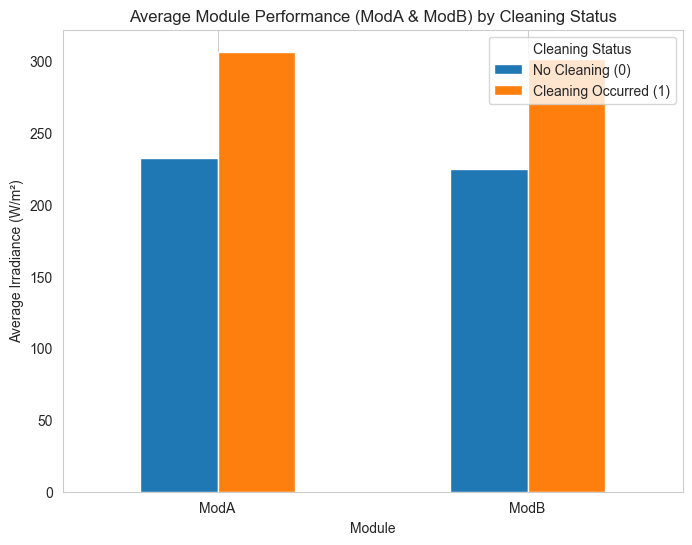


Average Module Performance by Cleaning Status:
                 ModA       ModB
Cleaning                       
0         232.323881  224.95509
1         306.610124  301.45000


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Ensure the cleaned data is loaded (This is safe to run again)

df_clean = pd.read_csv('./data/benin_clean.csv', index_col='Timestamp', parse_dates=True)

# --- 1. Calculate Average Module Performance by Cleaning Status ---

# Group the data by the 'Cleaning' flag and calculate the mean for modules A and B
# Cleaning = 1 (cleaning occurred), Cleaning = 0 (no cleaning occurred)
cleaning_impact = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean()

# --- 2. Plotting the Impact ---

# Transpose the data for better plotting (Metrics on X-axis, Cleaning Status in bars)
cleaning_impact.T.plot(kind='bar', figsize=(8, 6), rot=0)

plt.title('Average Module Performance (ModA & ModB) by Cleaning Status')
plt.ylabel('Average Irradiance (W/m²)')
plt.xlabel('Module')
plt.legend(title='Cleaning Status', labels=['No Cleaning (0)', 'Cleaning Occurred (1)'])
plt.grid(axis='y')
plt.show()

print("\nAverage Module Performance by Cleaning Status:\n", cleaning_impact)

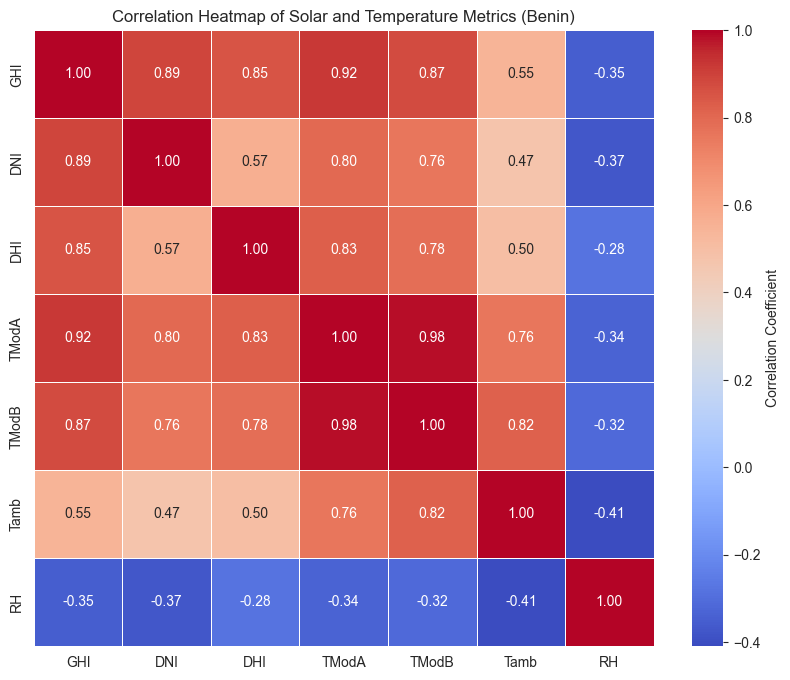

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the cleaned data is loaded (This is safe to run again)
df_clean = pd.read_csv('./data/benin_clean.csv', index_col='Timestamp', parse_dates=True)

# --- 1. Calculate Correlation Matrix ---

# Columns specified for correlation analysis
CORR_COLS = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH']

# Compute the Pearson correlation matrix
correlation_matrix = df_clean[CORR_COLS].corr()

# --- 2. Plotting the Heatmap ---

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Show the correlation values
    cmap='coolwarm',     # Color scheme
    fmt=".2f",           # Format to 2 decimal places
    linewidths=.5,       # Add lines between cells
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title('Correlation Heatmap of Solar and Temperature Metrics (Benin)')
plt.show()

C:\Users\Mer\AppData\Local\Temp\ipykernel_8908\871949381.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_by_dir = df_clean.groupby('WD_Sector')['WS'].mean().reindex(labels, fill_value=0)


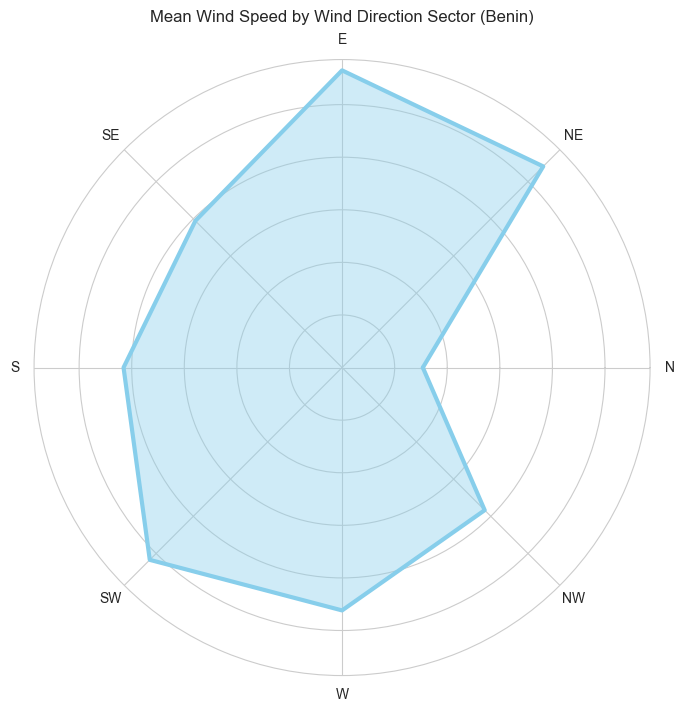

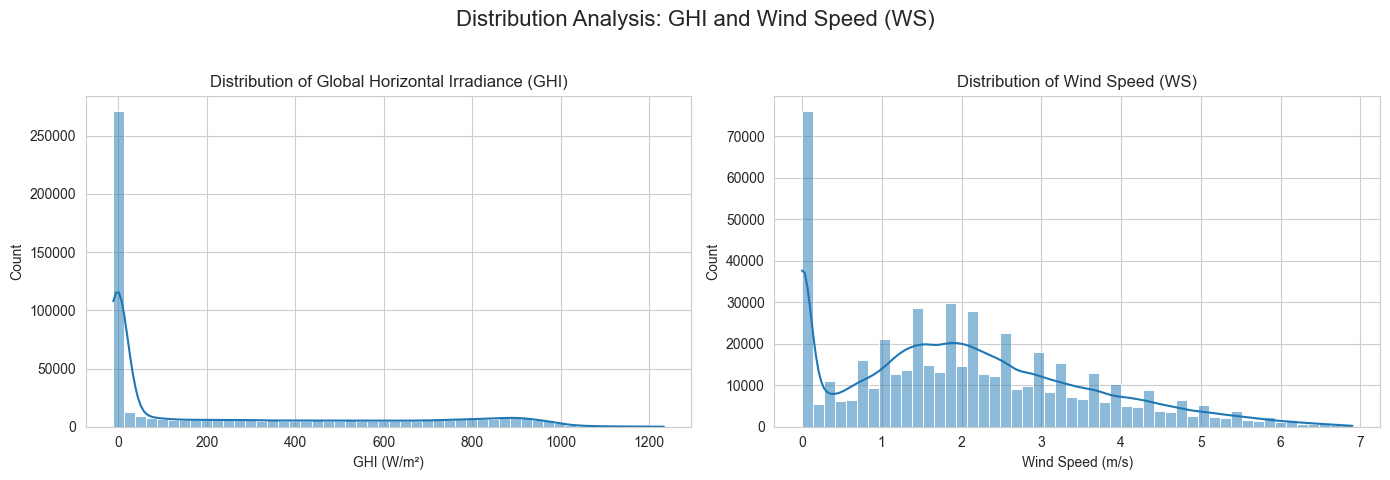

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Ensure the cleaned data is loaded 
df_clean = pd.read_csv('./data/benin_clean.csv', index_col='Timestamp', parse_dates=True)

# --- 1. Prepare Data for Radial Plot (Wind Rose Approximation) ---

# FIX: Use 9 bin edges to create 8 bins (0-360 degrees)
bins = np.linspace(0, 360, 9) 
labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
df_clean['WD_Sector'] = pd.cut(df_clean['WD'], bins=bins, labels=labels, right=False, ordered=False)

# Group by the sector and calculate the mean Wind Speed (WS)
wind_by_dir = df_clean.groupby('WD_Sector')['WS'].mean().reindex(labels, fill_value=0)

# --- 2. Plotting the Radial Bar Chart ---

# Convert directions to angles (radians) for plotting
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
wind_values = wind_by_dir.values
# Append the first value/angle to close the polar plot loop
wind_values = np.concatenate((wind_values, [wind_values[0]])) 
angles = np.concatenate((angles, [angles[0]]))

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, wind_values, color='skyblue', linewidth=3, linestyle='solid')
ax.fill(angles, wind_values, color='skyblue', alpha=0.4)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticklabels([]) # Hide y-axis labels for cleaner plot
ax.set_title('Mean Wind Speed by Wind Direction Sector (Benin)', va='bottom')
plt.show()

# --- 3. Histograms ---

# Histograms for GHI and one other variable (WS)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Distribution Analysis: GHI and Wind Speed (WS)', fontsize=16)

# Histogram for GHI
sns.histplot(df_clean['GHI'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Global Horizontal Irradiance (GHI)')
axes[0].set_xlabel('GHI (W/m²)')

# Histogram for Wind Speed (WS)
sns.histplot(df_clean['WS'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Wind Speed (WS)')
axes[1].set_xlabel('Wind Speed (m/s)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

C:\Users\Mer\AppData\Local\Temp\ipykernel_8908\20169650.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df_clean[['GHI', 'Tamb', 'RH']].resample('H').mean().dropna()


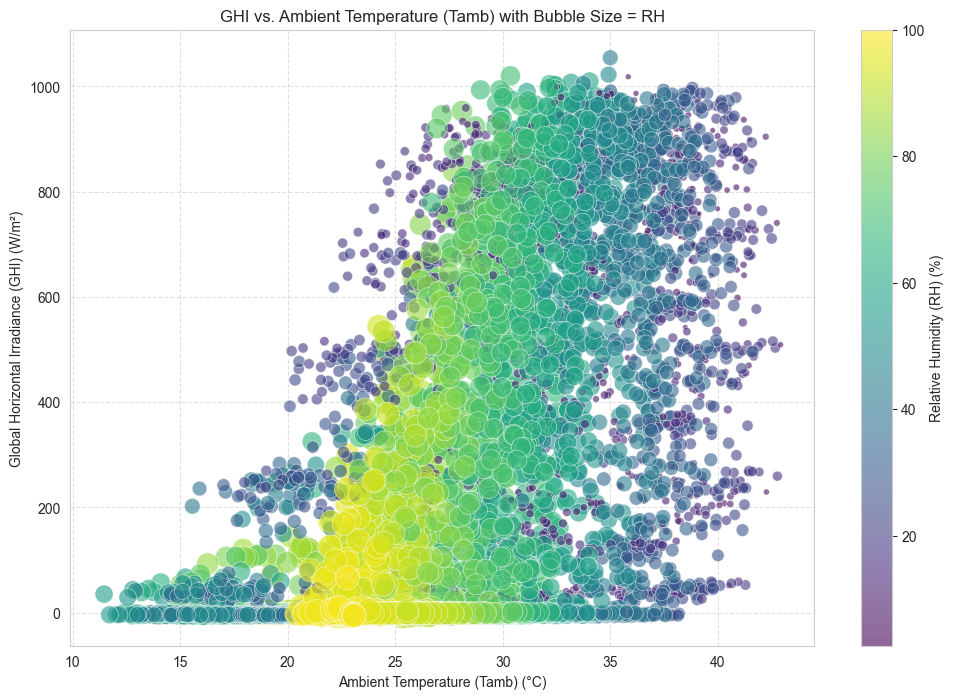

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Ensure the cleaned data is loaded 
df_clean = pd.read_csv('./data/benin_clean.csv', index_col='Timestamp', parse_dates=True)

# --- 1. Prepare Data for Bubble Chart ---

# Sample the data to avoid overcrowding the plot, which would hide the bubble effect
# Using a 1-hour resample of the mean is a good compromise
df_resampled = df_clean[['GHI', 'Tamb', 'RH']].resample('H').mean().dropna()

# Normalize the RH values for use as bubble size (scaling factor)
# Max bubble size of 300 is arbitrary but visually effective
scaling_factor = 300 / df_resampled['RH'].max()
df_resampled['RH_size'] = df_resampled['RH'] * scaling_factor

# --- 2. Plotting the Bubble Chart ---

plt.figure(figsize=(12, 8))

# Create the scatter plot with GHI vs. Tamb, where bubble size is RH
scatter = plt.scatter(
    x=df_resampled['Tamb'],
    y=df_resampled['GHI'],
    s=df_resampled['RH_size'], # Size is based on scaled RH
    c=df_resampled['RH'],       # Color is also based on RH for visual redundancy
    cmap='viridis',
    alpha=0.6,
    edgecolors='w',
    linewidth=0.5
)

# Add a color bar to interpret the bubble color (RH)
cbar = plt.colorbar(scatter, label='Relative Humidity (RH) (%)')

plt.title('GHI vs. Ambient Temperature (Tamb) with Bubble Size = RH')
plt.xlabel('Ambient Temperature (Tamb) (°C)')
plt.ylabel('Global Horizontal Irradiance (GHI) (W/m²)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()